In [ ]:
%%capture
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip install pyvirtualdisplay
!pip install pyglet==1.5.1

In [ ]:
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [ ]:
import numpy as np

from collections import deque

import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib.pyplot as plt
import matplotlib.animation as animation

from IPython.display import HTML

import gym
import imageio

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print(device)

cpu


In [ ]:
env_id = "CartPole-v1"
# env_id = "MountainCar-v0"
env = gym.make(env_id)

eval_env = gym.make(env_id)

s_size = env.observation_space.shape[0]
a_size = env.action_space.n

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
print("_____OBSERVATION SPACE_____ \n")
print("The State Space is: ", s_size)
print("Sample observation", env.observation_space.sample()) # Get a random observation

_____OBSERVATION SPACE_____ 

The State Space is:  4
Sample observation [-5.4754138e-02  2.0553640e+38  3.2457930e-01 -3.1166123e+37]


In [ ]:
print("\n _____ACTION SPACE_____ \n")
print("The Action Space is: ", a_size)
print("Action Space Sample", env.action_space.sample()) # Take a random action


 _____ACTION SPACE_____ 

The Action Space is:  2
Action Space Sample 1


In [ ]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [ ]:
def reinforce(policy, optimizer, scheduler, n_training_episodes, max_t, gamma, print_every):
    scores_deque = deque(maxlen=100)
    scores = []

    for i_episode in range(1, n_training_episodes+1):
        saved_log_probs = []
        rewards = []
        state = env.reset()

        for t in range(max_t):
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        returns = deque(maxlen=max_t)
        n_steps = len(rewards)
        for t in range(n_steps)[::-1]:
            disc_return_t = (returns[0] if len(returns)>0 else 0)
            returns.appendleft( gamma*disc_return_t + rewards[t]   )

        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)

        policy_loss = []
        for log_prob, disc_return in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * disc_return)
        policy_loss = torch.cat(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        scheduler.step()

        if i_episode % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    return scores

In [ ]:
def evaluate_agent(env, max_steps, n_eval_episodes, policy):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param policy: The Reinforce agent
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      action, _ = policy.act(state)
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

In [ ]:
hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 0.95,
    "lr": 2e-3,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

In [ ]:
policy = Policy(hyperparameters["state_space"], hyperparameters["action_space"], hyperparameters["h_size"]).to(device)
optimizer = optim.Adam(policy.parameters(), lr=hyperparameters["lr"])
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)

In [ ]:
scores = reinforce(policy,
                   optimizer,
                   scheduler,
                   hyperparameters["n_training_episodes"],
                   hyperparameters["max_t"],
                   hyperparameters["gamma"],
                   100)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 23.04
Episode 200	Average Score: 47.66
Episode 300	Average Score: 131.24
Episode 400	Average Score: 242.40
Episode 500	Average Score: 201.26
Episode 600	Average Score: 287.90
Episode 700	Average Score: 433.95
Episode 800	Average Score: 436.31
Episode 900	Average Score: 466.01
Episode 1000	Average Score: 320.88


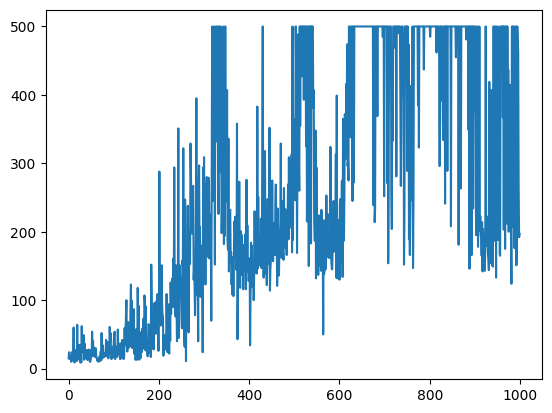

In [ ]:
plt.plot(list(range(len(scores))), scores)
plt.show()

In [ ]:
evaluate_agent(eval_env,
               hyperparameters["max_t"],
               hyperparameters["n_evaluation_episodes"],
               policy)

(395.3, 111.71127964534288)

In [ ]:
def record_video(env, policy, fps=30):
    images = []
    done = False
    state = env.reset()
    img = env.render(mode='rgb_array')
    images.append(img)
    while not done:
        action, _ = policy.act(state)
        state, reward, done, info = env.step(action)
        img = env.render(mode='rgb_array')
        images.append(img)
    return images

In [ ]:
images = record_video(env, policy)

/usr/local/lib/python3.11/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning

In [ ]:
fig, ax = plt.subplots()

n_frames = len(images)

def update(i):
    img = images[i]
    ax.clear()
    ax.imshow(img)
    ax.axis('off')

ani = animation.FuncAnimation(fig, update, frames=n_frames, interval=100)
plt.close()
HTML(ani.to_jshtml())